In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils # For y values
from keras.models import Sequential
from keras import metrics
from keras.layers.core import Dense, Dropout
from keras import backend as K

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
np.random.seed(123)  # for reproducibility

## Some Helping Functions

In [3]:
def print_heatmap(data):
    plt.imshow(data, cmap='jet', interpolation='nearest')
    plt.show()

In [4]:
def get_predicted_values(output_values):
    predicted_values = []
    for probability in output_values:
        if probability[0] > probability[1]:
            predicted_values.append(0)
        else:
            predicted_values.append(1)
    return predicted_values

# Reading the data

First we read the Signal Data and produce a heatmap from the average of all lines. We do so, in order to get the feeling of what our data looks like.

In [5]:
signal_data = pd.read_table('signal_PU0_13TeV_MJ-65-95_PTJ-950-1000.txt', header=None, dtype=np.float32)
print(signal_data.shape)
print(signal_data.iloc[1:10,625])

(9987, 626)
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: 625, dtype: float32


As seen, the data read has a last column (no. 626) without data. This happens because the data read has trailing spaces. We need to remove such data.

In [6]:
signal_data.drop(625, axis=1, inplace=True)
print(signal_data.shape)

(9987, 625)


Then, we calculate the average of all observations.

In [7]:
mean_signal = signal_data.mean()
print(mean_signal.iloc[1:10,])

1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
dtype: float32


Now draw the Heatmap

(625,)


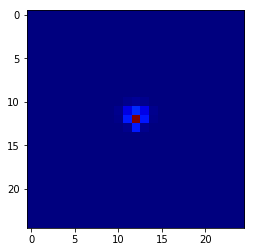

In [8]:
mean_signal_matrix = mean_signal.as_matrix()
print(mean_signal_matrix.shape)
mean_signal_matrix = mean_signal_matrix.reshape((25,25))

print_heatmap(mean_signal_matrix)

We then add a last column, with the value of `1`. This last column classify this data as signal data. After creating the full dataset we will rename this column to _class_.

In [9]:
signal_data[625] = 1

In [10]:
signal_data.iloc[0:10,625]

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: 625, dtype: int64

After preprocessing the _signal_ data, we will perform the same steps with the _background_ data.

In [11]:
backgroud_data = pd.read_table('background_PU0_13TeV_MJ-65-95_PTJ-950-1000.txt', header=None, dtype=np.float32)
print(backgroud_data.shape)

(9586, 626)


In [12]:
backgroud_data.drop(625, axis=1, inplace=True)
print(backgroud_data.shape)

(9586, 625)


In [13]:
mean_background = backgroud_data.mean()
print(mean_background.iloc[1:10,])

1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
dtype: float32


(625,)


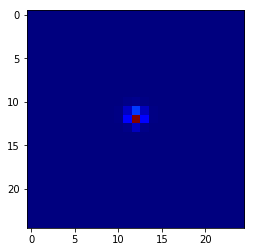

In [14]:
mean_background_matrix = mean_background.as_matrix()
print(mean_background_matrix.shape)
mean_background_matrix = mean_background_matrix.reshape((25,25))

print_heatmap(mean_background_matrix)

We modify this data, to point out that this is the background data, by setting the last column to `0`.

In [15]:
backgroud_data[625] = 0

In [16]:
backgroud_data.iloc[0:10,625]

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: 625, dtype: int64

Now we concatenate the data and shuffle it in order to randomize its columns.

In [17]:
frames = [signal_data, backgroud_data]
full_data = pd.concat(frames)

In [18]:
full_data = full_data.sample(frac=1).reset_index(drop=True)
full_data.rename(columns={625:'class'}, inplace=True)

Now let's examine how our data looks like.

In [19]:
from IPython.core.display import display
with pd.option_context('display.max_rows', 200, 'display.max_columns', 15, 
                       'display.float_format', '{:.2f}'.format):
    display(full_data)

,0,1,2,3,4,5,6,...,619,620,621,622,623,624,class
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,1
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0


# Defining and Training the model

Split the full dataset into _test_ and _train_ data in a 70-30% rate.

In [20]:
train_data, test_data = train_test_split(full_data, test_size = 0.3)
print(train_data.shape)
print(test_data.shape)

(13701, 626)
(5872, 626)


The _Keras_ framework, in order to train its network must receive the dependent and independent variables in  separated tables.

In [21]:
X_train = train_data.iloc[:, :-1]
print(X_train.shape)
Y_train = train_data.iloc[:,-1:]
print(Y_train.shape)

(13701, 625)
(13701, 1)


In [22]:
X_test = test_data.iloc[:, :-1]
print(X_test.shape)
Y_test = test_data.iloc[:,-1:]
print(Y_test.shape)

(5872, 625)
(5872, 1)


We must convert the dependent variable to be a probability distribution of the possible outcomes, thus, a value of output `1` must become the probabilities `(0, 1)`. Conversely, a `0` outcome value must become the pair `(1, 0)`.

In [23]:
Y_train = Y_train.as_matrix()
Y_train = np_utils.to_categorical(Y_train, num_classes=2)

## Neural Network Architecture Definition

We defined a simple NN, with only two hidden layer, each with 256 neurons and a _Dropout_, discarding 20% of the neurons at each layer. We used a rectified linear unit as the activation function.  
For the training phase we used a categorical crossentropy loss function, that is responsible for calculating how wrong our guess is, compared to the true value.  
The value of the loss function is then used to update the weights in the neurons connections. It uses an optimization function to minimize the loss value at the specific layer. In our example we used the _Adam_ optimizer, a version of the stochastic gradient descent.

In [24]:
dimof_input = X_train.shape[1]
model = Sequential()
model.add(Dense(units=256, kernel_initializer='uniform', activation='relu', input_dim=dimof_input))
model.add(Dropout(0.2))
model.add(Dense(units=256, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=2, kernel_initializer='uniform', activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=[metrics.categorical_accuracy, metrics.mean_squared_error])

After defining the NN architecture we train it using the `fit` method. We trained it for 50 epochs (backpropagation cycles). 

In [25]:
model.fit(X_train.as_matrix(), Y_train, batch_size=500, epochs=50, verbose=0)

After training the model we need to evaluate it.

In [26]:
Y_test = Y_test.as_matrix()
Y_test = np_utils.to_categorical(Y_test, num_classes=2)

In [27]:
score = model.evaluate(X_test.as_matrix(), Y_test, verbose=0)
print(model.metrics_names)
print(score)

['loss', 'categorical_accuracy', 'mean_squared_error']
[0.42721926857405201, 0.82084468664850141, 0.13236153184636737]


Now let's take a look at the missclassified observations.

In [28]:
Y_test_predicted = model.predict(X_test.as_matrix(), verbose=0)

In [29]:
Y_test_predicted

array([[ 0.66231608,  0.33768398],
       [ 0.45276895,  0.54723102],
       [ 0.01029896,  0.98970103],
       ..., 
       [ 0.01677139,  0.98322868],
       [ 0.09448448,  0.90551555],
       [ 0.82349551,  0.17650449]], dtype=float32)

Now we calculate the false negatives and also the false positives by comparing the true value with the predicted one.

In [30]:
Y_test_predicted_values = get_predicted_values(Y_test_predicted)
Y_test_values = get_predicted_values(Y_test)
print(Y_test_predicted_values[1:10])
print(Y_test_values[1:10])

false_positives = []
false_negatives = []
for i in range(len(Y_test_values)):
    if Y_test_values[i] == 0 and Y_test_predicted_values[i] == 1:
        false_positives.append(i)
    elif Y_test_values[i] == 1 and Y_test_predicted_values[i] == 0:
        false_negatives.append(i)
        
print("False Positive Rate: {:.2f}".format(len(false_positives)/len(Y_test_values)))
print("False Negative Rate: {:.2f}".format(len(false_negatives)/len(Y_test_values)))

[1, 1, 1, 1, 0, 1, 0, 1, 1]
[0, 1, 1, 1, 0, 0, 0, 1, 1]
False Positive Rate: 0.11
False Negative Rate: 0.07


And try to visualize the heatmaps for false positives and negatives. Firstly the false negatives, where the network was supposed to answer _Signal_, but instead, it answered _Background_.

[13, 14, 21, 24, 48, 74, 97, 101, 102]
(410, 625)
(625,)


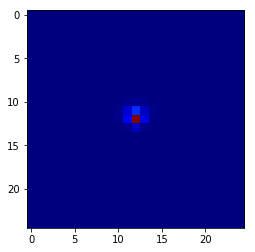

In [31]:
print(false_negatives[1:10])
false_negatives_values = X_test.iloc[false_negatives,]
print(false_negatives_values.shape)

mean_false_negatives = false_negatives_values.mean().as_matrix()
print(mean_false_negatives.shape)
mean_false_negatives = mean_false_negatives.reshape((25,25))

print_heatmap(mean_false_negatives)

Then we examine the cases in which the network should have responded _Background_, but it answered _Signal_.

[6, 12, 16, 40, 41, 49, 51, 54, 61]
(642, 625)
(625,)


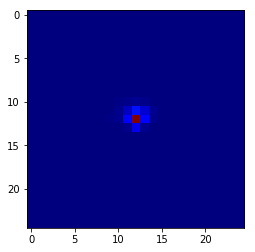

In [32]:
print(false_positives[1:10])
false_positives_values = X_test.iloc[false_positives,]
print(false_positives_values.shape)

mean_false_positives = false_positives_values.mean().as_matrix()
print(mean_false_positives.shape)
mean_false_positives = mean_false_positives.reshape((25,25))

print_heatmap(mean_false_positives)

In [33]:
K.clear_session()